# Predicting Sydney Property Prices

**Author:** Yenul Weerabahu  
**Date created:** 2024/06/21  
**Last modified:** 2024/07/28  
**Description:** Regression of Sydney Property Prices Using Neural Networks


## Layout
This notebook accompanies the final report for this project. The layout of this notebook is as follows
1. [Set-up](#setup)
2. [Downloading data](#downloadingdata) 
3. [Data cleaning](#datacleaning) 
4. [Exploratory Data Analysis (EDA)](#eda)
5. [Fitting the benchmark model](#RFmodel)
6. [Fitting the first neural network (simple feedforward)](#NN1)
7. [Fitting the second neural network (wide and deep)](#NN2)

## Set-up <a id="setup"></a>
If any of the following libraries are not installed, please ensure to do so.

In [79]:
#Import Packages
import time
import gdown
import random
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm
from properscoring import crps_ensemble
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
import keras.backend as K
import keras_tuner as kt
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Embedding, Concatenate, Dropout  
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.losses import Loss
from keras.optimizers import Adam
from scipy import stats
from scipy.stats import norm, lognorm
from scipy.integrate import quad

set_config(transform_output="pandas")

## Downloading Data <a id="downloadingdata"></a>
The `propertydata.csv` file will be downloaded from the cloud.

In [80]:
# Download Data from Web (Adapted from ChatGPT)
file_id = '1mhVVmzR-hSrQP-FOBH_AELAiew4u6M7c'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'propertydata.csv')

# Import Data Using Pandas
data = pd.read_csv('propertydata.csv')

Downloading...
From: https://drive.google.com/uc?id=1mhVVmzR-hSrQP-FOBH_AELAiew4u6M7c
To: C:\Users\yenul\propertydata.csv
100%|██████████| 21.2M/21.2M [00:05<00:00, 4.21MB/s]


In [81]:
# Show first five rows of data
prop_sales = data
prop_sales.head(5) 

,Date,suburb,postalCode,bed,bath,car,propType,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd,sellPrice
0,1/01/2022,Prestons,2170.0,4.0,2,2.0,House,15313.0,36244.0,9.215,-33.94155,150.87334,28.0,0.1,220.1,32.26,1087500
1,1/01/2022,Ourimbah,NaN,3.0,2,2.0,House,3951.0,37180.0,87.154,-33.31517,151.32611,191.0,0.1,220.1,61.95,1000000
2,31/12/2021,Kellyville,2155.0,4.0,3,2.0,House,27971.0,46228.0,18.645,-33.69583,150.95622,78.0,0.1,220.1,30.08,1900000
3,31/12/2021,Seven Hills,2147.0,7.0,3,2.0,House,19326.0,33540.0,9.629,-33.77743,150.94272,38.0,0.1,220.1,26.58,1300000
4,31/12/2021,Sydney,2000.0,2.0,2,1.0,Apartment / Unit / Flat,17252.0,35412.0,2.940,-33.86794,151.20998,65.0,0.1,220.1,0.31,1025000


## Data Cleaning <a id="datacleaning"></a>
Although we will not be using the feature `Date` for the models, it will be used in the data cleaning process as an index. The data cleaning is organised as follows:
1. Identify how many rows of each feature variable is missing.
2. Remove rows with missing `property_inflation_index`
3. Remove rows with missing `postalCode`
   - Format as an integer
4. Replace missing suburb-specific data with median values
5. Format features `car`, `bed` and `bath` into floats
6. Set missing `cash_rate` values to 1.5 (reasoning provided in report)
7. Remove property sales with `sellPrice` below $100,000
8. Merge 23 categories for `propType` into 10
9. Remove `Date`, which is no longer needed

In [82]:
# Format Date into yyyymmdd
prop_sales['Date'] = pd.to_datetime(prop_sales['Date'], format='mixed')

# Table of the number of missing values per variable 
missing_values = prop_sales.isnull().sum()
print('Missing values per variable:')
print(missing_values)

Missing values per variable:
Date                            0
suburb                          0
postalCode                   1461
bed                           154
bath                            0
car                         18151
propType                        0
suburb_population           14479
suburb_median_income        14479
suburb_sqkm                 14479
suburb_lat                  14479
suburb_lng                  14479
suburb_elevation            14479
cash_rate                     867
property_inflation_index    32499
km_from_cbd                 14479
sellPrice                       0
dtype: int64


In [83]:
# Inspect sales which are missing property_inflation_index
prop_sales[prop_sales['property_inflation_index'].isnull()].head(5)

,Date,suburb,postalCode,bed,bath,car,propType,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd,sellPrice
6959,2000-01-12,Bondi Beach,2026.0,10.0,5,3.0,house,11656.0,64532.0,1.219,-33.89095,151.27247,18.0,NaN,NaN,6.46,3565000
6960,2006-04-01,Northmead,2152.0,4.0,2,2.0,house,11215.0,40924.0,4.286,-33.78379,150.99349,49.0,5.5,NaN,21.97,596000
6961,2006-01-17,Georges Hall,2198.0,5.0,1,1.0,house,9038.0,29640.0,3.323,-33.90761,150.98902,23.0,5.5,NaN,20.97,475000
6962,2006-01-19,Bondi Junction,2022.0,3.0,1,NaN,house,9445.0,54964.0,1.079,-33.89296,151.25030,89.0,5.5,NaN,4.85,750000
6963,2006-01-19,Tahmoor,2573.0,3.0,1,2.0,house,NaN,NaN,NaN,NaN,NaN,NaN,5.5,NaN,NaN,319000


In [84]:
# Drop rows with missing property_inflation_index
prop_sales = prop_sales.dropna(subset=['property_inflation_index'])

In [85]:
# Inspect sales which are missing postalCode
prop_sales[prop_sales['postalCode'].isnull()].head(5)

,Date,suburb,postalCode,bed,bath,car,propType,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd,sellPrice
1,2022-01-01,Ourimbah,NaN,3.0,2,2.0,House,3951.0,37180.0,87.154,-33.31517,151.32611,191.0,0.1,220.1,61.95,1000000
22,2021-12-24,Mannering Park,NaN,4.0,2,2.0,House,2472.0,28964.0,7.129,-33.16376,151.54040,7.0,0.1,220.1,83.63,2100000
23,2021-12-24,Mannering Park,NaN,2.0,2,2.0,House,2472.0,28964.0,7.129,-33.16376,151.54040,7.0,0.1,220.1,83.63,2050000
27,2021-12-24,Wyoming,NaN,5.0,3,3.0,House,10134.0,29380.0,7.138,-33.40534,151.36250,32.0,0.1,220.1,52.93,1450000
33,2021-12-24,Wyoming,NaN,4.0,2,2.0,House,10134.0,29380.0,7.138,-33.40534,151.36250,32.0,0.1,220.1,52.93,1200000


In [86]:
# Drop rows with missing postalCode
prop_sales = prop_sales.dropna(subset=['postalCode'])

# Format postalCode into integer
prop_sales['postalCode'] = prop_sales['postalCode'].astype(int)

In [87]:
# Replace missing Suburb-Specific data with median values
# Create function which replaces NA values with median (Adapted from Geron (2022))
def fill_with_median(data):
    return data.fillna(data.median())

# List with suburb-specific variables
suburb_data = [prop_sales.columns[3]] + [prop_sales.columns[5]] + prop_sales.columns[7:13].tolist() + [prop_sales.columns[15]]

# Set missing values to median
prop_sales[suburb_data] = prop_sales[suburb_data].apply(fill_with_median, axis=0)

In [88]:
# Format car into float
prop_sales['car'] = prop_sales['car'].astype(float)

# Format bed into float
prop_sales['bed'] = prop_sales['bed'].astype(float)

# Format bath into float
prop_sales['bath'] = prop_sales['bath'].astype(float)

In [89]:
# Inspect sales which are missing cash_rate            
prop_sales[prop_sales['cash_rate'].isnull()].sort_values(by='Date').head(5)

,Date,suburb,postalCode,bed,bath,car,propType,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd,sellPrice
152107,2019-01-01,West Pennant Hills,2125,4.0,3.0,3.0,house,16374.0,45500.0,9.292,-33.74763,151.03335,109.0,NaN,160.5,20.91,2300000
152108,2019-01-01,Kogarah Bay,2217,5.0,3.0,3.0,house,2022.0,36504.0,0.665,-33.98260,151.12424,19.0,NaN,160.5,15.25,1800000
153349,2019-01-13,Greystanes,2145,3.0,1.0,2.0,house,22802.0,33800.0,8.969,-33.82378,150.93855,62.0,NaN,160.5,25.53,735000
153350,2019-01-13,Cabramatta,2166,3.0,1.0,1.0,house,21783.0,20644.0,5.042,-33.89828,150.93609,14.0,NaN,160.5,25.60,1830000
153351,2019-01-13,Lansvale,2166,3.0,1.0,2.0,house,2570.0,25376.0,2.893,-33.89877,150.96071,5.0,NaN,160.5,23.35,710000


In [90]:
# Set missing cash_rate values to 1.5
prop_sales["cash_rate"].fillna(1.5, inplace=True)

In [91]:
# New table of missing values per variable for verification
prop_sales.isnull().sum()

Date                        0
suburb                      0
postalCode                  0
bed                         0
bath                        0
car                         0
propType                    0
suburb_population           0
suburb_median_income        0
suburb_sqkm                 0
suburb_lat                  0
suburb_lng                  0
suburb_elevation            0
cash_rate                   0
property_inflation_index    0
km_from_cbd                 0
sellPrice                   0
dtype: int64

In [92]:
# Remove properties with sellPrice below $100,000
prop_sales = prop_sales[prop_sales["sellPrice"] >= 100000]

In [93]:
# Values which propType can take
prop_sales["propType"].unique()

# Define new categorical variables for propType in dictionary
replace_dict = {
    'house': 'House',
    'Apartment / Unit / Flat': 'Apartment',
    'Block of Units': 'Apartment',
    'TownHouse': 'Townhouse', 
    'townHouse': 'Townhouse', 
    'Villa': 'Townhouse', 
    'New Apartments / Off the Plan': 'Apartment',
    'New House & Land': 'House',
    'Acreage / Semi-Rural' : 'Acreage',
    'Development Site': 'Vacant Land',
    'Studio': 'House',
    'duplex/semi-detached': 'Semi-Detached',
    'townhouse': 'Townhouse', 
    'terrace': 'Terrace',
    'villa': 'Townhouse',
    'acreage': 'Acreage',
    'New land': 'Vacant Land',
    'wareHouse': 'Warehouse',
    'warehouse': 'Warehouse',
    'Vacant land': 'Vacant Land',
    'other': 'Other'
}

prop_sales["propType"].replace(replace_dict, inplace=True)

# New categorical values for propType
prop_sales["propType"].unique()

array(['House', 'Apartment', 'Semi-Detached', 'Vacant Land', 'Duplex',
       'Townhouse', 'Terrace', 'Acreage', 'Warehouse', 'Other'],
      dtype=object)

In [94]:
# Remove Date feature
prop_sales = prop_sales.drop(columns=["Date"])

## Exploratory Data Analysis (EDA) <a id="eda"></a>
The EDA is composed of four main parts in addition to the calculation of additional numerical statistics.
1. [Distribution of property sales (indexed to 2011 $)](#hist)
2. [Correlation matrix between features](#corr)
3. [Scatterplot of property price vs. distance to CBD](#scatter)
4. [Mean property prices by type](#column)

All plots can be downloaded to local libraries. Just remove the `###` in the last line of the respective cell.

In [95]:
# Median property price, adjusted for housing inflation
(prop_sales["sellPrice"]/prop_sales["property_inflation_index"]*100).median()

745115.856428896

### Histogram of property prices <a id="hist"></a>

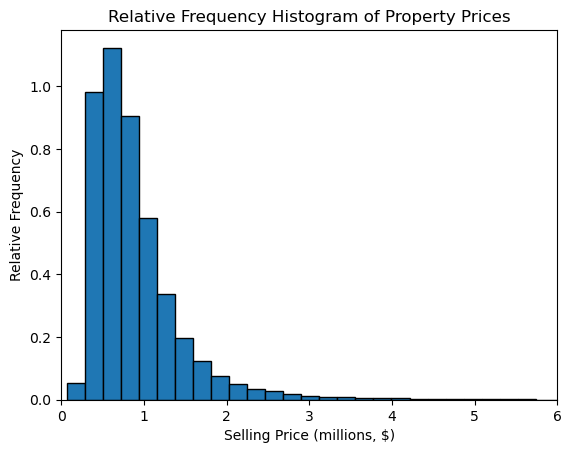

In [39]:
# Create histogram with sellPrice divided by property_inflation_index to use 2011 $
plt.hist((prop_sales["sellPrice"]/prop_sales["property_inflation_index"])/10000, bins = 500, density=True, edgecolor="black")

# Domain of x axis
plt.xlim(0, 6)

# Add title
plt.title("Relative Frequency Histogram of Property Prices")

# Add axes labels
plt.xlabel("Selling Price (millions, $)")
plt.ylabel("Relative Frequency");

### Export figure into Downloads folder
### plt.rcParams['svg.fonttype'] = 'none'
### plt.savefig('Downloads/property_price_histogram.svg', format='svg')

### Correlation Matrix <a id="corr"></a>

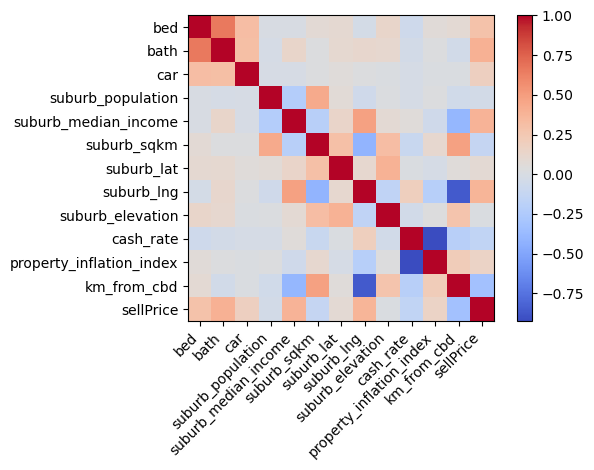

In [194]:
corr_df = prop_sales.drop(columns=['postalCode'])
corr_matrix = (corr_df.select_dtypes(include=['float64', 'int32', 'int64'])).corr()

# Visualize the correlation matrix using a heatmap (Adapted from ChatGPT)
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Adding labels to the plot
num_vars = corr_matrix.shape[0]
plt.xticks(np.arange(num_vars), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(num_vars), corr_matrix.index)

plt.tight_layout()

### Export figure into Downloads folder
### plt.savefig('Downloads/correlation_matrix.svg', format='svg')

### Scatterplot of Price vs. Distance from CBD <a id="scatter"></a>

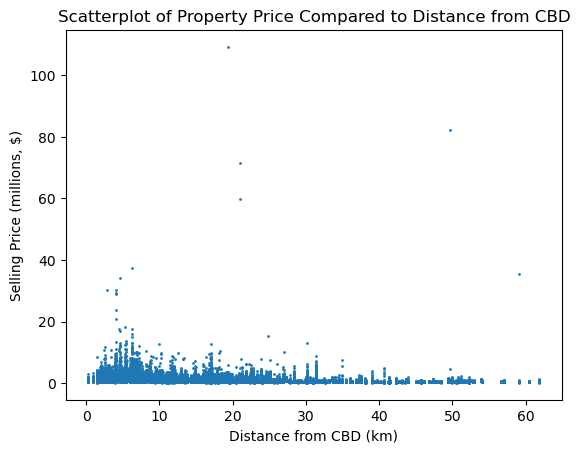

In [195]:
plt.scatter(prop_sales["km_from_cbd"], (prop_sales["sellPrice"]/prop_sales["property_inflation_index"])/10000, s=1)

# Add title
plt.title("Scatterplot of Property Price Compared to Distance from CBD")

# Add axes labels
plt.xlabel("Distance from CBD (km)")
plt.ylabel("Selling Price (millions, $)");

### Export figure into Downloads folder
### plt.savefig('Downloads/distance_scatter.svg', format='svg')

### Mean Property Prices by Property Type <a id="column"></a>

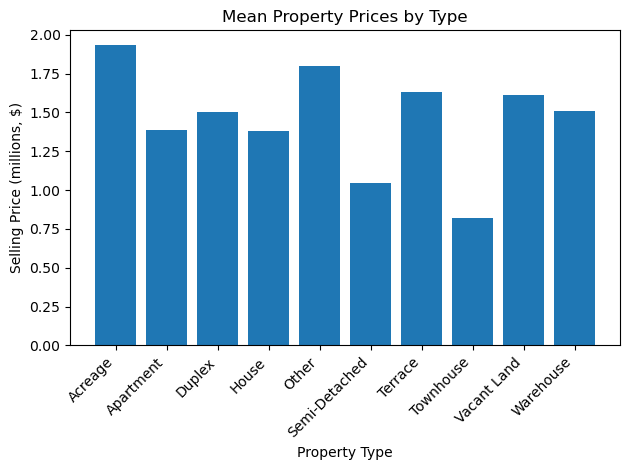

In [199]:
# Find mean price of each type of property
mean_values = (prop_sales.groupby("propType")["sellPrice"].mean())/1000000

# Create bar graph
plt.bar(mean_values.index, mean_values.values)

# Rotate x labels 
plt.xticks(rotation=45, ha='right')

# Axis titles
plt.xlabel("Property Type")
plt.ylabel("Selling Price (millions, $)")
plt.title("Mean Property Prices by Type")
plt.tight_layout()

### Export figure into Downloads folder
### plt.savefig('Downloads/propType.svg', format='svg')

## Random Forest Model <a id="RFmodel"></a>
This section is split into 5 sections.
1. Encoding of categorical variables
2. Creation of main and test sets
   - The main set is used as training for this model, but will later be further split into training and validation for the neural networks. This maximises the amount of data the random forest can be trained on.
3. Training model
4. Creation of `evaluate_RF` and `log_normal_nll` functions which allow the Negative Log-Likelihood (NLL) to be estimated under the assumption of a log-normal distribution.
5. Evaluating model on training and test sets

In [96]:
# Encode Categorical Variables
prop_sales_encoded = pd.get_dummies(prop_sales, columns=['suburb', 'propType', 'postalCode'], drop_first=True)

In [97]:
# Separate feature and target variables
features = prop_sales_encoded.drop(columns=['sellPrice'])
target = prop_sales_encoded['sellPrice'].astype(float)

# Split to Training and Test Sets for both Baseline and Neural Network Models
X_main, X_test, y_main, y_test = train_test_split(features, target, test_size=0.2, random_state=2024)

In [78]:
%%time

# Train BASELINE Random Forest Model
forest_reg = RandomForestRegressor(n_estimators=100, bootstrap=False, random_state=42, verbose=0)
forest_reg.fit(X_main, np.log(y_main))

CPU times: total: 6min 6s
Wall time: 8min 28s


RandomForestRegressor(bootstrap=False, random_state=42)

The NLL calculation involved directly computing the P.D.F. The NLL could not be estimated directly as `np.log` and `norm.logpdf` are from the NumPy and SciPy libraries respectively which are not compatible with Tensorflow. The NumPy/SciPy functions are more suitable for static computation rather than automatic differentiation. Although this is more relevant for the neural networks, for consistency, the same methodology was used for calculating the NLL for the random forest.

In [98]:
# Define function which evaulates RF with NLL as metric
#### The standard deviation of the predictions is estimated as the standard deviation of the residuals
def evaluate_RF(model, X, y_true):
    mean  = model.predict(X)

    residuals = mean - np.log(y_true)
    sigma = max(np.std(residuals), 1e-10)

    # Compute log-likelihood for log-normal distribution
    log_likelihood = -0.5 * ((np.log(y_true) - mean) ** 2 / (sigma ** 2)) - np.log(y_true) - 0.5 * np.log(2 * np.pi) - np.log(sigma)
    nll = np.round(-np.mean(log_likelihood), 4)
    
    print(f'Negative Log-Likelihood: {nll}')

In [76]:
# Run model on training set
evaluate_RF(forest_reg, X_main, y_main)

Negative Log-Likelihood: 14.7236


In [77]:
# Run model on test set
evaluate_RF(forest_reg, X_test, y_test)

Negative Log-Likelihood: 15.1564


## Neural Network 1 <a id="NN1"></a>
This is a simple feedforward network. This section is split into 7 sections.
1. Creation of training, validation and test sets
2. Pre-processing inputs
3. Defining a `nll_loss` function which is used as the loss function
4. Hyperparameter tuning of model based on `val_loss` with summary of all combinations of parameters used
5. Train neural network with network with best hyperparameters
6. Defining a `evaluate_NN` function which allows the Negative Log-Likelihood (NLL) to be calculated based on the mean and sd outputs from the neural network.
7. Evaluating model on training, validation and test sets
   - This includes the creation of a loss curve

In [99]:
# Separate feature and target variables
features = prop_sales.drop(columns=['sellPrice'])
target = prop_sales['sellPrice'].astype(float)

# Split to Training, Validation and Test Sets for both Neural Network Models
X_mainNN, X_testNN, y_mainNN, y_testNN = train_test_split(features, target, test_size=0.2, random_state=2024)
X_trainNN, X_valNN, y_trainNN, y_valNN = train_test_split(X_mainNN, y_mainNN, test_size=0.25, random_state=2024)

In [100]:
# Pre-process inputs
## One-hot encording on all Categorical Variables
all_attribs = list(features.columns)
cat_attribs = ["suburb", "postalCode", "propType"]
num_attribs = [attrib for attrib in all_attribs if attrib not in cat_attribs]
transform_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_attribs),
])

X_train_oh = transform_pipeline.fit_transform(X_trainNN)
X_val_oh = transform_pipeline.transform(X_valNN)
X_test_oh = transform_pipeline.transform(X_testNN)

In [101]:
# Define NLL loss function (Adapted from ChatGPT)
def nll_loss(y_true, y_pred):
    # As true y values are entered in log space, they need to be converted to unit form
    y_true = tf.math.exp(y_true)
    
    # First column output is the mean, second column in the std dev
    mean = y_pred[:, 0]
    sigma = y_pred[:, 1]
    
    # Compute log-likelihood for log-normal distribution
    log_likelihood = -0.5 * ((tf.math.log(y_true) - mean) ** 2 / (sigma ** 2)) - tf.math.log(y_true) - 0.5 * tf.math.log(2 * np.pi) - tf.math.log(sigma)
    
    return -tf.reduce_mean(log_likelihood)

In [29]:
# Hyper-parameter tuning
num_features = len(X_train_oh.columns)

def build_model1(hp):
    input_ = Input(shape=(num_features,), name="input")

    #Tuning number of neurons of first hidden layer
    hidden1_units = hp.Int('hidden1_units', min_value=112, max_value=256, step=16)
    hidden1 = Dense(hidden1_units, activation="leaky_relu", name="hidden1")(input_)

    hidden2 = Dense(32, activation="leaky_relu", name="hidden2")(hidden1)   
    hidden3 = Dense(16, activation="leaky_relu", name="hidden3")(hidden2)

    # Tuning activation function for the mean output
    mean_activation = hp.Choice('mean_activation', values=['softplus', 'linear', 'selu', 'exponential'])
    mean = Dense(1, activation=mean_activation, name="mean")(hidden3)
    
    sd = Dense(1, activation = "softplus", name = "sd")(hidden3)
    output = Concatenate(name="combined")([mean, sd])
    
    model1 = Model(inputs=[input_], outputs=[output])

    #Tuning of learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model1.compile(optimizer='adam', loss=nll_loss)
    
    return model1

# Use Bayesian search
tuner1 = kt.BayesianOptimization(
  build_model1,
  objective="val_loss",
  directory="bayesian-search-NN1",
  max_trials=10
)

es = EarlyStopping(restore_best_weights=True, patience=15)

tuner1.search(X_train_oh, np.log(y_trainNN), epochs=100, callbacks = [es], validation_data=(X_val_oh, np.log(y_valNN)))

Trial 10 Complete [00h 14m 21s]
val_loss: 14.725103378295898

Best val_loss So Far: 14.722869873046875
Total elapsed time: 01h 43m 54s


In [30]:
# Obtain a summary of all the trials
tuner1.results_summary()

Results summary
Results in bayesian-search-NN1\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
hidden1_units: 112
mean_activation: selu
lr: 0.0006045397453672276
Score: 14.722869873046875

Trial 04 summary
Hyperparameters:
hidden1_units: 208
mean_activation: linear
lr: 0.0002464202939394493
Score: 14.722911834716797

Trial 02 summary
Hyperparameters:
hidden1_units: 192
mean_activation: exponential
lr: 0.0009389203815514113
Score: 14.72315788269043

Trial 09 summary
Hyperparameters:
hidden1_units: 128
mean_activation: softplus
lr: 0.0004229956292625801
Score: 14.725103378295898

Trial 03 summary
Hyperparameters:
hidden1_units: 192
mean_activation: selu
lr: 0.00020648655741227194
Score: 14.725207328796387

Trial 05 summary
Hyperparameters:
hidden1_units: 224
mean_activation: softplus
lr: 0.0011200350152365897
Score: 14.7255220413208

Trial 07 summary
Hyperparameters:
hidden1_units: 144
mean_activation: selu
lr: 0.0020

In [31]:
# Get the best combination hyperparameters (Adapted from ChatGPT)
best_hps = tuner1.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of neurons in the hidden1 layer is: {best_hps.get('hidden1_units')}")
print(f"The optimal activation function for the mean output is: {best_hps.get('mean_activation')}")
print(f"The optimal learning rate is: {best_hps.get('lr')}")

The optimal number of neurons in the hidden1 layer is: 112
The optimal activation function for the mean output is: selu
The optimal learning rate is: 0.0006045397453672276


In [32]:
# Build and train the model with the best hyperparameters
model1 = tuner1.hypermodel.build(best_hps)
hist1 = model1.fit(X_train_oh, np.log(y_trainNN), callbacks = [es], epochs=1000, validation_data=(X_val_oh, np.log(y_valNN)))

Epoch 1/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 21.5030 - val_loss: 14.8067
Epoch 2/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 14.8162 - val_loss: 14.7796
Epoch 3/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 14.7896 - val_loss: 14.7611
Epoch 4/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 14.7821 - val_loss: 14.7789
Epoch 5/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 14.7753 - val_loss: 14.8101
Epoch 6/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 14.7674 - val_loss: 14.7448
Epoch 7/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 14.7704 - val_loss: 14.7629
Epoch 8/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 14.7668 - val_loss: 14.7495
Epoch 9/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 14.7645 - val_loss: 14.7478
Epoch 10/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 14.7595 - val_loss: 14.7436
Epoch 11/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 14.7514 - val

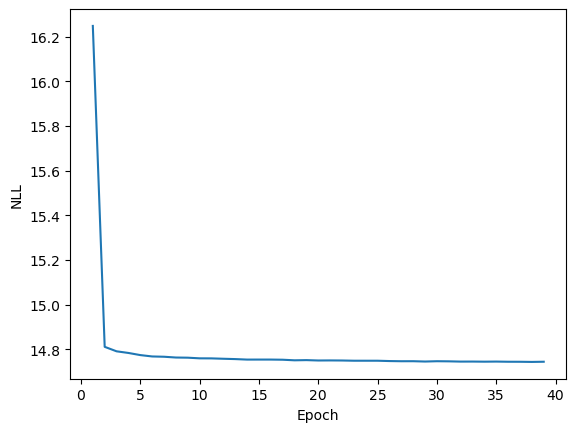

In [40]:
# Construct loss curve
plt.plot(range(1, 40), hist1.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("NLL");

### plt.savefig('Downloads/NN1-Loss-Curve.svg', format='svg')

In [102]:
# Define function which evaulates RF with NLL as metric
def evaluate_NN(model, X, y_true):
    y_pred = model.predict(X)
    mean = y_pred[:, 0]
    sigma = y_pred[:, 1]

    # Compute log-likelihood for log-normal distribution
    log_likelihood = -0.5 * ((np.log(y_true) - mean) ** 2 / (sigma ** 2)) - np.log(y_true) - 0.5 * np.log(2 * np.pi) - np.log(sigma)
    nll = -tf.reduce_mean(log_likelihood)
    print(f'Negative Log-Likelihood: {np.round(nll, 4)}')

In [48]:
# Run first NN on training set
evaluate_NN(model1, X_train_oh, y_trainNN)

3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step
Negative Log-Likelihood: 14.6975


In [49]:
# Run first NN on validation set
evaluate_NN(model1, X_val_oh, y_valNN)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step
Negative Log-Likelihood: 14.6912


In [50]:
# Run first NN on test set
evaluate_NN(model1, X_test_oh, y_testNN)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step
Negative Log-Likelihood: 14.6949


## Neural Network 2 <a id="NN2"></a>
This is a more complex Wide & Deep network with dropout. This section is split into 4 sections and depends on the pre-processing and creation of the `nll_loss` function from [Neural Network 1](#NN1).
1. Hyperparameter tuning of model based on `val_loss` with summary of all combinations of parameters used
2. Train neural network with network with best hyperparameters
2. Evaluating model on training, validation and test sets
   - This includes the creation of a loss curve

In [51]:
# Hyper-parameter tuning
def build_model2(hp):
    input_ = Input(shape = (num_features,), name="input")
    hidden1 = Dense(112, activation="leaky_relu", name="hidden1")(input_)
    dropout1 =  Dropout(0.2, name='dropout1')(hidden1)
    hidden2 = Dense(32, activation="leaky_relu", name="hidden2")(dropout1)
    dropout2 =  Dropout(0.2, name='dropout2')(hidden2)

    # Tune number of neurons in third hidden layer
    hidden3_units = hp.Int('hidden3_units', min_value=4, max_value=32, step=4)
    hidden3 = Dense(hidden3_units, activation="leaky_relu", name="hidden3")(dropout2)

    # Tuning of rate of third dropout layer
    dropout_rate3 = hp.Float('dropout_rate3', min_value=0.0, max_value=0.5, step=0.05)
    dropout3 =  Dropout(dropout_rate3, name='dropout3')(hidden3)
 
    concat = Concatenate(name="combined")([input_, dropout3])
    mean = Dense(1, activation = "selu", name = "mean")(concat)
    sd = Dense(1, activation = "softplus", name = "sd")(concat)
    output = Concatenate(name="combined_output")([mean, sd])    
    model2 = Model(inputs=[input_], outputs=[output])

    # Tuning of learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    # Loss function is same as NN1
    model2.compile(optimizer='adam', loss=nll_loss)
    
    return model2

# Use Bayesian search
tuner2 = kt.BayesianOptimization(
  build_model2,
  objective="val_loss",
  directory="bayesian-search-NN2",
  max_trials=10
)

es = EarlyStopping(restore_best_weights=True, patience=15)

tuner2.search(X_train_oh, np.log(y_trainNN), epochs=100, callbacks = [es], validation_data=(X_val_oh, np.log(y_valNN)))

Trial 10 Complete [00h 04m 31s]
val_loss: 14.72359848022461

Best val_loss So Far: 14.723591804504395
Total elapsed time: 02h 14m 26s


In [84]:
# Obtain a summary of all the trials
tuner2.results_summary()

Results summary
Results in bayesian-search-NN2\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
hidden3_units: 12
dropout_rate3: 0.1
lr: 0.00374755979723867
Score: 14.734262466430664

Trial 04 summary
Hyperparameters:
hidden3_units: 8
dropout_rate3: 0.25
lr: 0.007191048334401892
Score: 14.735143661499023

Trial 00 summary
Hyperparameters:
hidden3_units: 40
dropout_rate3: 0.05
lr: 0.0004900688590401333
Score: 14.735356330871582

Trial 09 summary
Hyperparameters:
hidden3_units: 28
dropout_rate3: 0.1
lr: 0.00348925819843469
Score: 14.735512733459473

Trial 06 summary
Hyperparameters:
hidden3_units: 20
dropout_rate3: 0.0
lr: 0.0013203367674065015
Score: 14.735546112060547

Trial 01 summary
Hyperparameters:
hidden3_units: 40
dropout_rate3: 0.2
lr: 0.00012071356508240166
Score: 14.735722541809082

Trial 07 summary
Hyperparameters:
hidden3_units: 4
dropout_rate3: 0.0
lr: 0.0002963442135421521
Score: 14.735901832580566

Tria

In [53]:
# Get the best combination hyperparameters (Adapted from ChatGPT)
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of neurons in the hidden3 layer is: {best_hps2.get('hidden3_units')}")
print(f"The optimal rate of dropout in the dropout3 layer is: {best_hps2.get('dropout_rate3')}")
print(f"The optimal learning rate is: {best_hps2.get('lr')}")

The optimal number of neurons in the hidden3 layer is: 16
The optimal rate of dropout in the dropout3 layer is: 0.05
The optimal learning rate is: 0.00017887307871975


In [54]:
# Build and train the model with the best hyperparameters
model2 = tuner2.hypermodel.build(best_hps2)
hist2 = model2.fit(X_train_oh, np.log(y_trainNN), callbacks = [es], epochs=1000, validation_data=(X_val_oh, np.log(y_valNN)))

Epoch 1/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 32.4197 - val_loss: 15.6201
Epoch 2/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 15.9291 - val_loss: 15.3141
Epoch 3/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 15.6331 - val_loss: 14.9423
Epoch 4/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 15.1745 - val_loss: 14.8138
Epoch 5/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 15.0063 - val_loss: 14.7766
Epoch 6/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 14.9480 - val_loss: 14.7700
Epoch 7/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 14.8928 - val_loss: 14.7736
Epoch 8/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 14.8598 - val_loss: 14.7522
Epoch 9/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 14.8287 - val_loss: 14.7391
Epoch 10/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 14.8071 - val_loss: 14.7479
Epoch 11/1000
3249/3249 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 14.7890 - val_

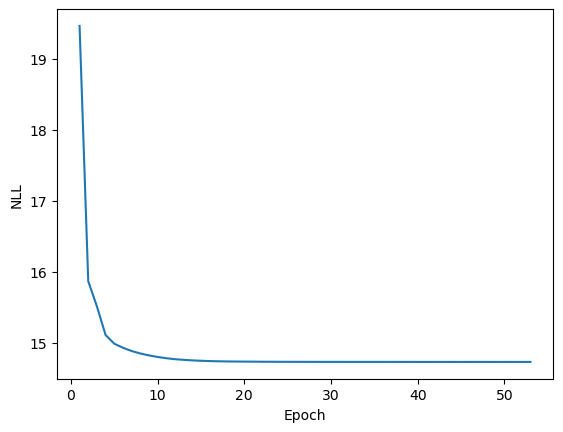

In [55]:
# Construct loss curve
plt.plot(range(1, 27), hist2.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("NLL");

### plt.savefig('Downloads/NN2-Loss-Curve.svg', format='svg')

In [56]:
# Run second NN on training set
evaluate_NN(model2, X_train_oh, y_trainNN)

3249/3249 ━━━━━━━━━━━━━━━━━━━━ 2s 658us/step
Negative Log-Likelihood: 14.6964


In [57]:
# Run second NN on validation set
evaluate_NN(model2, X_val_oh, y_valNN)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step
Negative Log-Likelihood: 14.6895


In [58]:
# Run second NN on test set
evaluate_NN(model2, X_test_oh, y_testNN)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Negative Log-Likelihood: 14.6947
